## Previsão de Faturamento para Controladoria

Este notebook tem como objetivo aplicar técnicas de análise de dados e previsão de faturamento com foco na área de controladoria.

### 1. Importação de Bibliotecas e Dados

In [1]:
# Manipulação e Análise de Dados
import pandas as pd              
import sidetable as stb 
import numpy as np  

# Análises gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Modelagem
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from mlxtend.frequent_patterns import apriori, association_rules

# Configuração
import warnings
warnings.filterwarnings('ignore')

# Utilitários personalizados
import importlib 
import sys                      

if '.' not in sys.path:
    sys.path.append('.')

import src.eda_utils as eda_utils

importlib.reload(eda_utils)

# Pré-processamento de dados
from category_encoders import TargetEncoder, OrdinalEncoder, OneHotEncoder 
from sklearn.impute import SimpleImputer  
from imblearn.pipeline import Pipeline as ImbPipeline  
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer

In [2]:
# Carregar os dados
df = pd.read_csv('SaaS-Sales.csv')

### 2. Análise Exploratória dos Dados (EDA)

In [3]:
# Visualizar primeiras linhas
df.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,row_id,order_id,order_date,date_key,contact_name,country,city,region,subregion,customer,customer_id,industry,segment,product,license,sales,quantity,discount,profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


#### Dicionário dos dados

**row_id** - Identificador único de cada linha do dataset  
**order_id** - Identificador único do pedido. Pode haver múltiplas linhas por pedido  
**order_date** - Data em que o pedido foi realizado  
**date_key** - Representação numérica da data (ex: YYYYMMDD)  
**contact_name** - Nome da pessoa responsável pelo pedido  
**country** - País onde o cliente está localizado  
**city** - Cidade onde o cliente está localizado  
**region** - Região geográfica  
**subregion** - Subdivisão da região  
**customer** - Nome da empresa ou organização  
**customer_id** - Identificador único da empresa ou organização  
**industry** - Setor de atuação do da empresa ou organização  
**segment** - Segmento de mercado  
**product** - Nome do produto vendido  
**license** - Tipo de licença adquirida  
**sales** - Valor monetário total da venda  
**quantity** - Quantidade de licenças ou produtos vendidos  
**discount** - Valor do desconto aplicado na venda  
**profit** - Lucro obtido na venda (receita - custo - desconto)  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   row_id        9994 non-null   int64  
 1   order_id      9994 non-null   object 
 2   order_date    9994 non-null   object 
 3   date_key      9994 non-null   int64  
 4   contact_name  9994 non-null   object 
 5   country       9994 non-null   object 
 6   city          9994 non-null   object 
 7   region        9994 non-null   object 
 8   subregion     9994 non-null   object 
 9   customer      9994 non-null   object 
 10  customer_id   9994 non-null   int64  
 11  industry      9994 non-null   object 
 12  segment       9994 non-null   object 
 13  product       9994 non-null   object 
 14  license       9994 non-null   object 
 15  sales         9994 non-null   float64
 16  quantity      9994 non-null   int64  
 17  discount      9994 non-null   float64
 18  profit        9994 non-null 

In [6]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['order_date'].dtype

dtype('<M8[ns]')

In [7]:
df.stb.missing(style=True)

,missing,total,percent
row_id,0,"9,994",0.00%
order_id,0,"9,994",0.00%
order_date,0,"9,994",0.00%
date_key,0,"9,994",0.00%
contact_name,0,"9,994",0.00%
country,0,"9,994",0.00%
city,0,"9,994",0.00%
region,0,"9,994",0.00%
subregion,0,"9,994",0.00%
customer,0,"9,994",0.00%


In [8]:
df.stb.missing(style=True)

,missing,total,percent
row_id,0,"9,994",0.00%
order_id,0,"9,994",0.00%
order_date,0,"9,994",0.00%
date_key,0,"9,994",0.00%
contact_name,0,"9,994",0.00%
country,0,"9,994",0.00%
city,0,"9,994",0.00%
region,0,"9,994",0.00%
subregion,0,"9,994",0.00%
customer,0,"9,994",0.00%


In [9]:
df.describe()

,row_id,order_date,date_key,customer_id,sales,quantity,discount,profit
count,9994.000000,9994,9.994000e+03,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2022-05-01 00:07:12.259355648,2.021803e+07,1049.771963,229.858001,3.789574,0.156203,28.656896
min,1.000000,2020-01-04 00:00:00,2.020010e+07,1001.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2021-05-23 00:00:00,2.021052e+07,1024.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2022-06-27 00:00:00,2.022063e+07,1049.000000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2023-05-15 00:00:00,2.023052e+07,1076.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2023-12-31 00:00:00,2.023123e+07,1101.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,1.123898e+04,29.719388,623.245101,2.225110,0.206452,234.260108


Os dados possuem data entre 01/2020 a 12/2023, ou seja, temos dados referente a 4 anos de venda.  
Média de vendas de $229,86, porém com mediana de $54,49, indicando que podemos ter muitos outiliers puxando o valor da média para cima, tendo em vista a diferença entre a média e a mediana e o desvio padrão elevado de 623,24.  
Os descontos parecem ser muito agrassivos, com mediana de 20% mas com máximo de 80%, o que pode estar atrapalhando os resultados das vendas  
Temos que analisar o lucro, pois temos prejuízos elevados em algumas transações. Verificar se tem relação com o produto, cliente ou desconto ofericido.

In [10]:
df.stb.counts()

,count,unique,most_freq,most_freq_count,least_freq,least_freq_count
region,9994,3,EMEA,4219,APJ,2110
segment,9994,3,SMB,5191,Enterprise,1783
industry,9994,10,Finance,2127,Misc,107
subregion,9994,12,NAMER,2507,EU,110
discount,9994,12,0.0,4798,0.45,11
product,9994,14,ContactMatcher,1842,Alchemy,68
quantity,9994,14,3,2409,12,23
country,9994,48,United States,2001,Slovenia,1
customer,9994,99,Allianz,192,Citigroup,22
customer_id,9994,99,1080,192,1020,22


O segmento de SMB (Small and Medium-sized Businesses), ou seja, Pequenas e Médias Empresas, possui mais da metade das transações. O que pode ser ruim pela concentração de mercado. Comparar ticket médio e margem entre os setores.   
Aproximadamente metade das transações não possuem desconto, porém conforme vimos anteriormente, na outra metade dos dados os descontos são elevados em certas transações. Verificar se esses descontos tem relação com cliente, produto, região ou valor da venda.  
Temos 14 tipos de produtos, porém aproximadamente 20% das transações são do produto ContactMatcher, verificar o motivo de tantas vendas. É o mais barato? Mais divulgado? Analisar margem de lucro.  

### Etapa 3 - Separação entre treino e teste  
Antes de qualquer modelagem, precisamos garantir que conseguiremos avaliar o modelo de forma justa e realista.  
Por isso, dividimos o dataset em dois subconjuntos: treino e teste.  

- O conjunto de treino será usado para ensinar o modelo;  
- O conjunto de teste será guardado para avaliar a performance final, simulando como o modelo se sairia em novos dados do "mundo real".  

Isso é essencial para medir a capacidade de generalização. Um modelo que vai bem apenas nos dados de treino pode estar "decorando" e não aprendendo de fato.

In [11]:
df = df.sort_values('order_date')
df.set_index('order_date', inplace=True)  

split_point = int(len(df) * 0.8)
train = df.iloc[:split_point]
test = df.iloc[split_point:]

y_train = train['sales']
y_test = test['sales']

X_train = train.drop('sales', axis=1)
X_test = test.drop('sales', axis=1)

In [12]:
X_train = X_train.drop(columns=['row_id', 'date_key','customer_id','license','customer'], axis=1)

In [13]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,order_id,contact_name,country,city,region,subregion,industry,segment,product,quantity,discount,profit,sales
order_date,,,,,,,,,,,,,
2020-01-04,APJ-2020-103800,Brian Dickens,Japan,Tokyo,APJ,JAPN,Manufacturing,SMB,Support,2,0.2,5.5512,16.448
2020-01-05,APJ-2020-112326,Liam Churchill,Australia,Wollongong,APJ,ANZ,Retail,Enterprise,FinanceHub,3,0.2,4.2717,11.784
2020-01-05,APJ-2020-112326,Liam Churchill,Australia,Wollongong,APJ,ANZ,Retail,Enterprise,Marketing Suite - Gold,3,0.2,-64.7748,272.736
2020-01-05,APJ-2020-112326,Liam Churchill,Australia,Wollongong,APJ,ANZ,Retail,Enterprise,ContactMatcher,2,0.8,-5.4870,3.540
2020-01-06,EMEA-2020-141817,Ella Springer,France,Paris,EMEA,EU-WEST,Manufacturing,SMB,ChatBot Plugin,3,0.2,4.8840,19.536


In [14]:
train['unit_price'] = train['sales'] / train['quantity']
train['gross'] = train['profit'] / (train['quantity'] * train['unit_price'])

In [15]:
numerical_features = train.select_dtypes('number').columns.tolist()

print(f'O dataset possui {len(numerical_features)} variáveis numéricas.')
print(numerical_features)

O dataset possui 6 variáveis numéricas.
['quantity', 'discount', 'profit', 'sales', 'unit_price', 'gross']


<Axes: xlabel='order_date'>

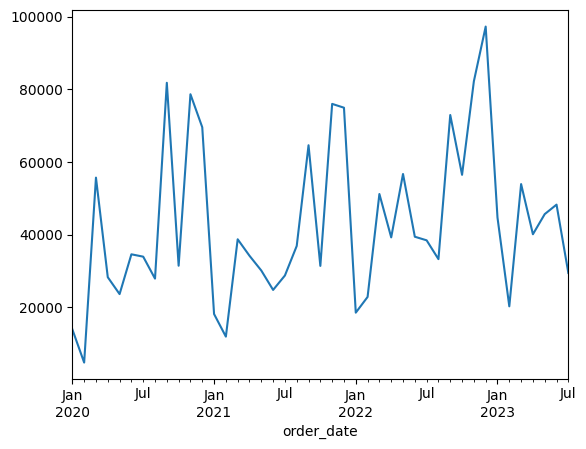

In [16]:
train.resample('M')['sales'].sum().plot()

<Axes: xlabel='order_date'>

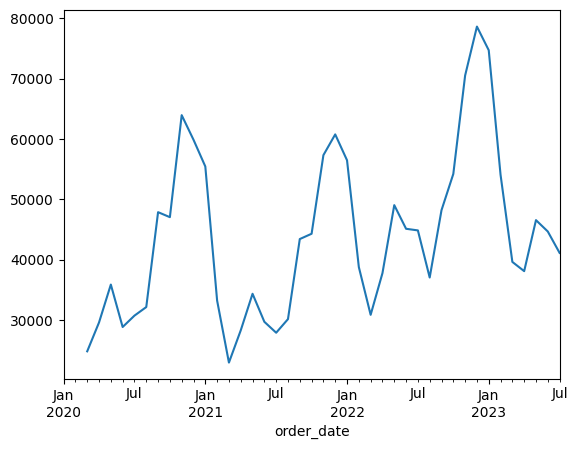

In [17]:
train.resample('M')['sales'].sum().rolling(window=3).mean().plot()

Vizivelmente as vendas passam por sazonalidades, com picos e vales nos mesmos períodos todos os anos. Com picos de venda em setembro, novembro e dezembro, e queda nas vendas nos dois primeiros meses de cada ano.

Podemos ver que as vendas estão crescendo ano após ano com picos mais altos que os picos anteriores e vales mais altos que vales anteriores comparando os mesmos períodos.

Alta volatilidade, pois a variação de mês a mês é elevada.

Verificar a possibilidade de realizar campanhas para atrair um maior público nos meses de queda.


In [18]:
train.groupby('product')[['sales','profit','quantity', 'discount', 'unit_price', 'gross']].mean().round(2).sort_values(by='sales')

,sales,profit,quantity,discount,unit_price,gross
product,,,,,,
Storage,13.41,3.90,4.21,0.08,3.22,0.28
ChatBot Plugin,35.03,8.44,3.74,0.07,9.00,0.25
SaaS Connector Pack - Gold,69.77,29.43,3.63,0.08,20.21,0.42
Support,80.75,21.53,3.75,0.07,22.37,0.39
SaaS Connector Pack,96.89,13.75,3.77,0.14,25.93,0.13
ContactMatcher,215.18,10.42,3.86,0.36,57.81,-0.20
Data Smasher,217.05,53.78,3.82,0.08,56.11,0.22
OneView,217.34,36.37,3.62,0.17,59.68,-0.15
Marketing Suite - Gold,273.41,25.20,3.79,0.08,72.10,0.08


In [19]:
vendas_produto = df.groupby('product')['sales'].sum().sort_values(ascending=False)
vendas_produto_pct = vendas_produto / vendas_produto.sum()
vendas_produto_cum_pct = vendas_produto_pct.cumsum()


In [20]:
pareto = vendas_produto_cum_pct[vendas_produto_cum_pct <= 0.80]
produtos_mais_relevantes = pareto.index
print(produtos_mais_relevantes)

Index(['ContactMatcher', 'FinanceHub', 'Site Analytics',
       'Marketing Suite - Gold', 'Big Ol Database', 'Data Smasher', 'Alchemy'],
      dtype='object', name='product')


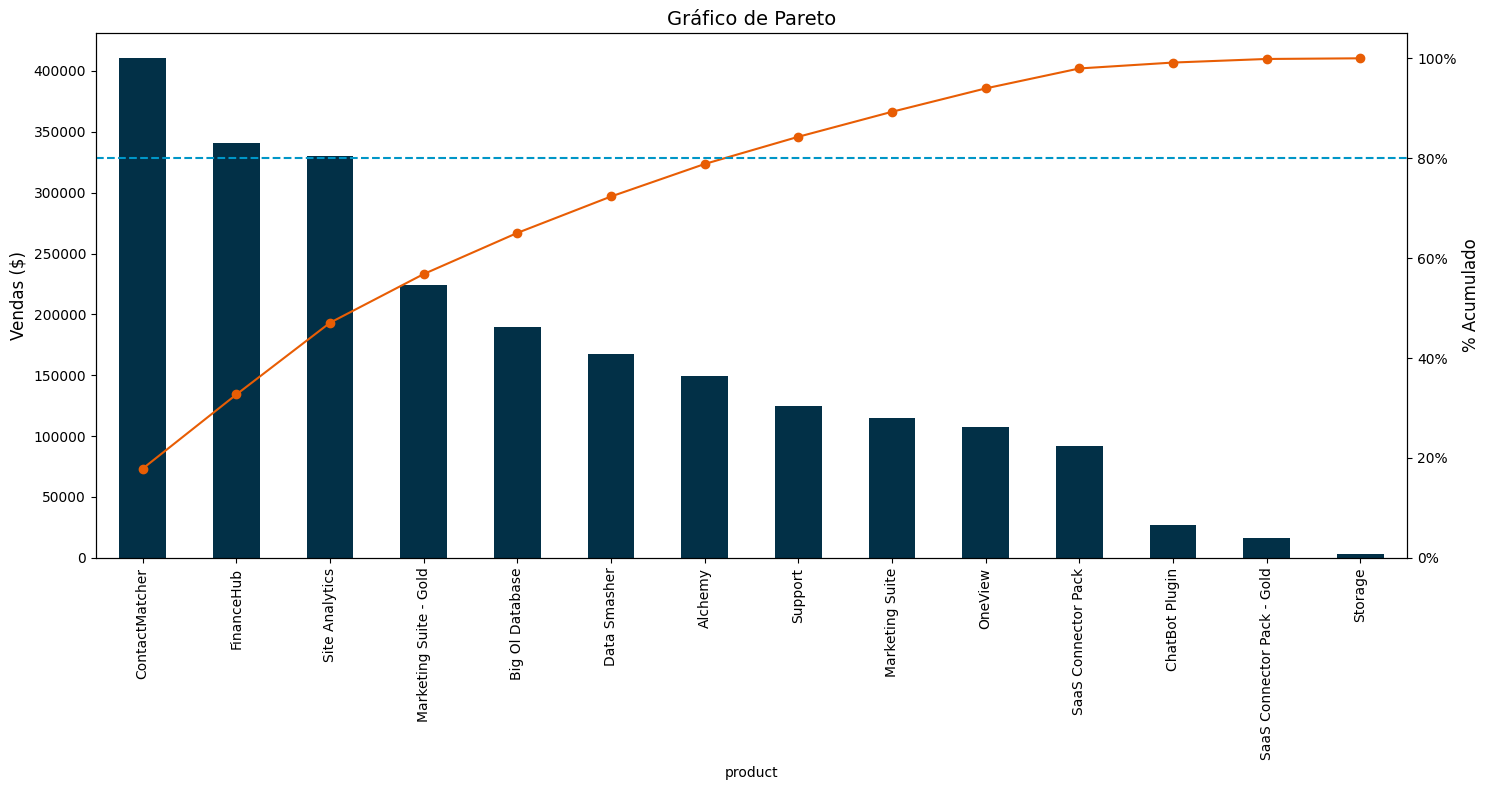

In [21]:
fig, ax1 = plt.subplots(figsize=(15,8))

vendas_produto.plot(kind='bar', color='#023047', ax=ax1)
ax1.set_ylabel('Vendas ($)', fontsize=12)

ax2 = ax1.twinx()
vendas_produto_cum_pct.plot(color='#e85d04', marker='o', ax=ax2)
ax2.axhline(0.80, color='#0096c7', linestyle='--')
ax2.set_ylabel('% Acumulado', fontsize=12)
ax2.set_ylim([0,1.05])
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.title('Gráfico de Pareto', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Analisando o gráfico acima vemos que 50% dos produtos são responsáveis por 80% das vendas. Isso significa que os outros 7 produtos equivalem aos 20% restantes. Verificar juntamente com as demais equipes a possibilidade de remover/alterar alguns produtos que não possuem muita relevância nas vendas.

In [22]:
train.groupby('region')[['sales','profit','quantity', 'discount', 'unit_price', 'gross']].mean().round(2).sort_values(by='sales')

,sales,profit,quantity,discount,unit_price,gross
region,,,,,,
APJ,197.25,5.71,3.77,0.27,52.19,-0.15
AMER,230.23,33.96,3.77,0.11,62.15,0.22
EMEA,248.67,37.73,3.81,0.14,64.73,0.17


In [23]:
train.loc[train['region'] == 'APJ','country'].unique()

array(['Japan', 'Australia', 'Philippines', 'India', 'New Zealand',
       'South Korea', 'Taiwan', 'China', 'Singapore', 'Indonesia'],
      dtype=object)

Verificar juntamente com as equipes envolvidas porque os países listados acima possuem em média o dobro de descontos quando comparado aos demais países mesmo tendo o preço unitário em torno de 18% mais barato. Está afetando o lucro, sendo em torno de 7x menor do que as demais regiões e a margem estando negativa.

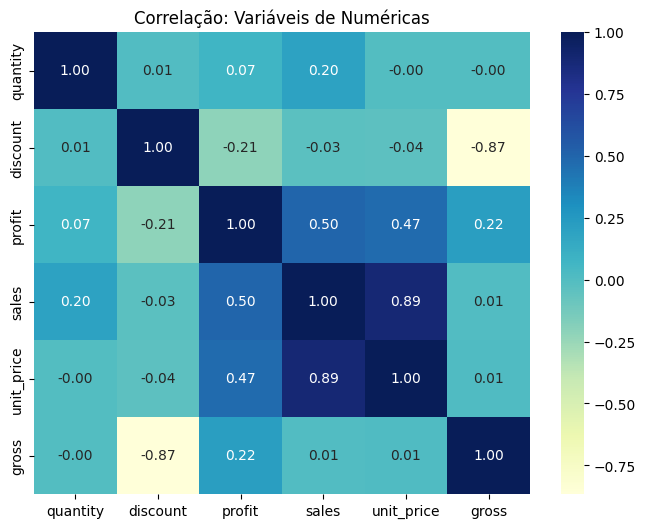

In [60]:
corr_matrix = train[numerical_features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlação: Variáveis de Numéricas')
plt.show()


Correlação alta entre disconto e margem, sendo muito forte negativamente, ou seja, quanto maior o desconto, menor a margem
- Realizar o monitoramento da política de descontos
- Monitorar campanhas promocionais
- Criar regra de aprovação de grandes descontos

As vendas com o preço unitário positivamente, ou seja, ambas variáveis sobem juntas.

Vendas e lucro, correlação moderada. Isso indica alerta, pois na teoria a correlação deveria ser maior, porém os descontos altos podem estar impactando esse valor ou os custos estão elevados.

Preço unitário, em teoria, também deveria ter uma correlação mais elevada, mas está mostrando uma correlação fraca, mostrando que o preço não é a única variável que importa para um maior lucro.
- Verificar quais produtos com preço elevado que não possuem relevância nas vendas.

Quantidade não possui correlação alta com nada, sendo assim, priorizar ticket alto e margem.

In [83]:
products = train.groupby('product').agg({
    'unit_price': 'mean',
    'quantity': 'sum'
})
display(products.sort_values(by=['unit_price', 'quantity'], ascending=[False, True]))

,unit_price,quantity
product,,
Alchemy,547.446145,194
Big Ol Database,434.208771,365
Marketing Suite,133.729770,740
Site Analytics,101.181707,2633
FinanceHub,89.918331,3030
Marketing Suite - Gold,72.097478,2537
OneView,59.675187,1333
ContactMatcher,57.813087,5679
Data Smasher,56.110969,2311


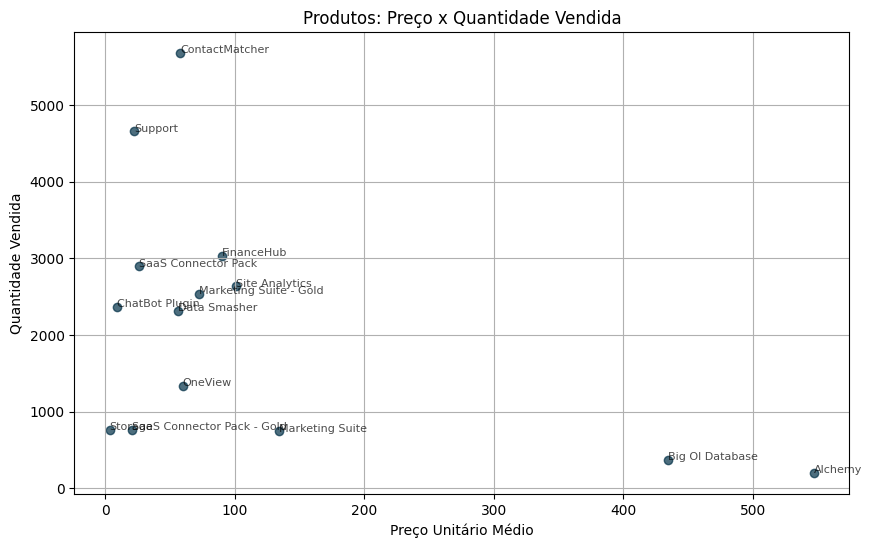

In [84]:
plt.figure(figsize=(10, 6))
plt.scatter(products['unit_price'], products['quantity'], alpha=0.7)

for produto, row in products.iterrows():
    plt.text(row['unit_price'], row['quantity'], produto, fontsize=8, alpha=0.7)

plt.xlabel('Preço Unitário Médio')
plt.ylabel('Quantidade Vendida')
plt.title('Produtos: Preço x Quantidade Vendida')
plt.grid(True)
plt.show()

Produtos de alto valor agregado podem ter baixa rotatividade, mas ainda assim são críticos para o faturamento total. Já que os produtos Alchemy e Big Ol Database fazem parte dos produtos com maiores relevâncias no pareto.
- Verificar ações de marketing direcionadas, pois o valor percebido é elevado

Os produtos SaaS Connector Pack - Gold e Storage são os dois ultimos produtos do pareto, ou seja, que possuem menor relevância na receita, além disso possuem baixa saída.
- Verificar a possibilidade de descontinuação dos produtos ou redefinir valor.

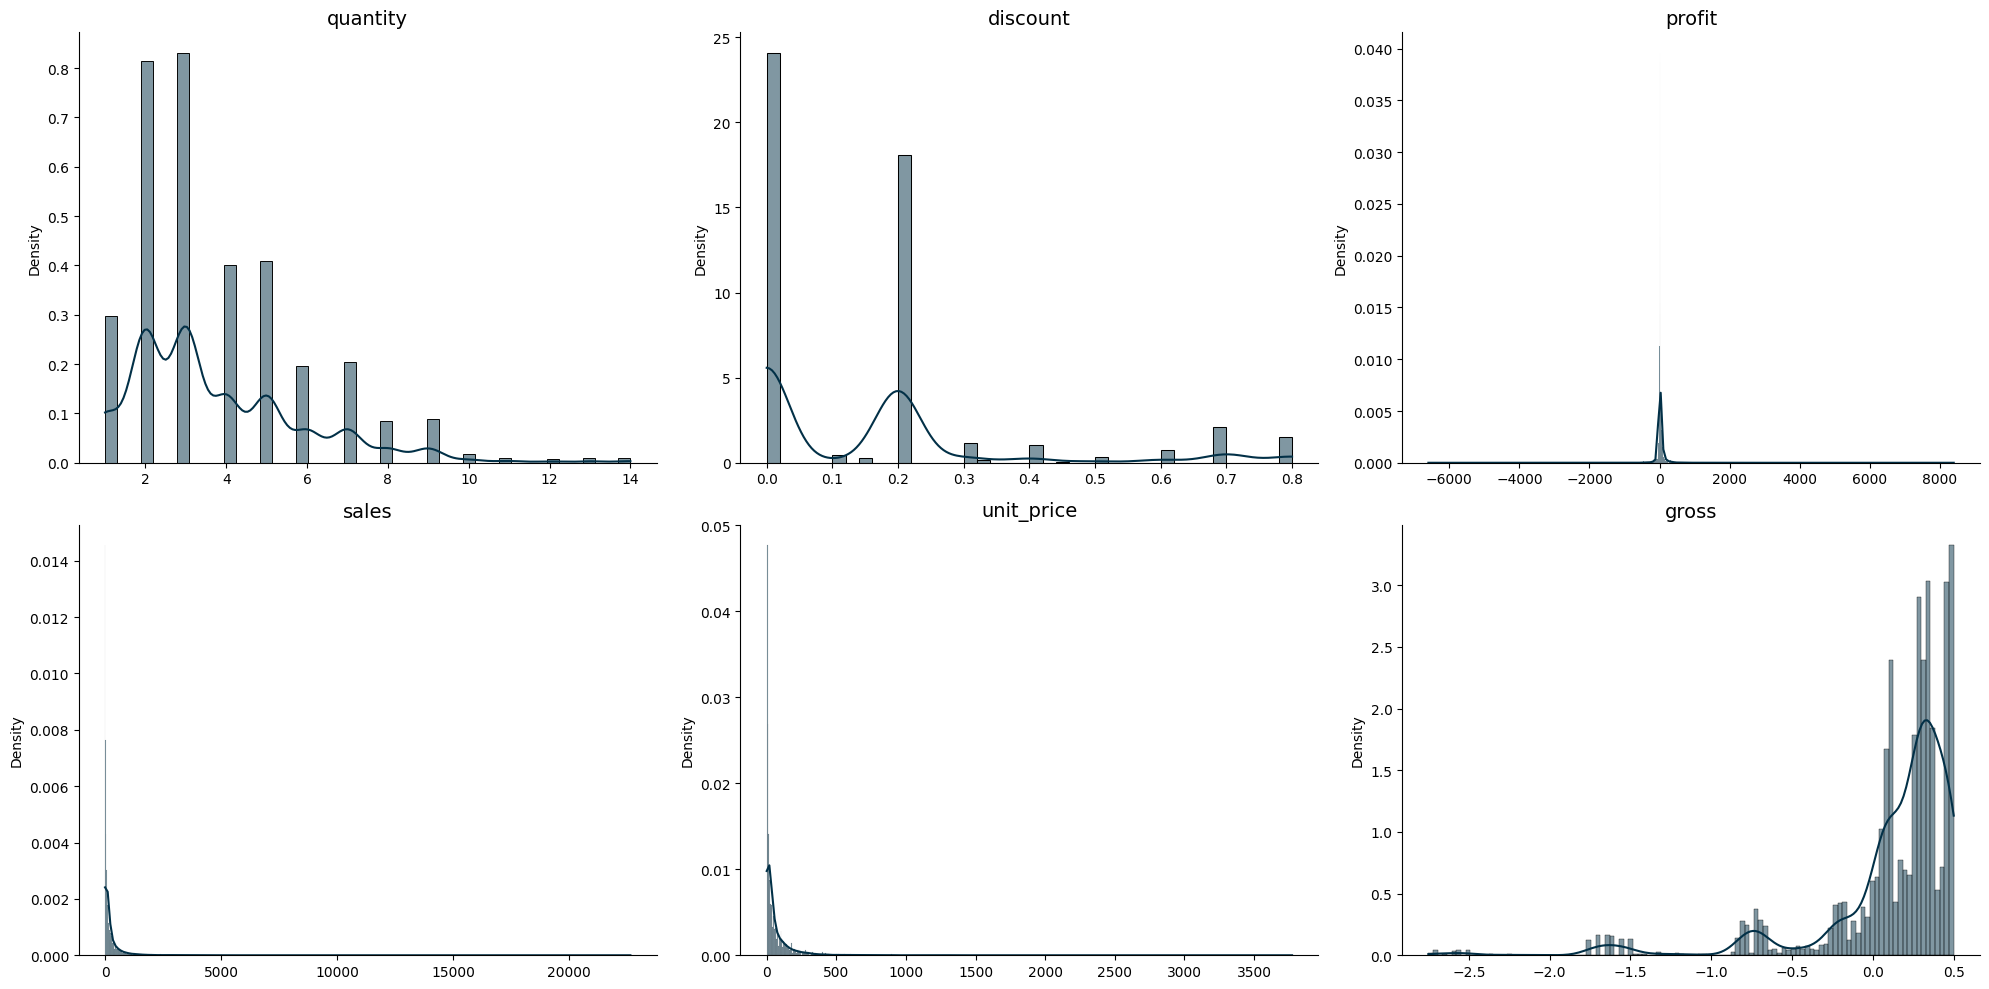

In [24]:
eda_utils.plot_graph(data=train, features=numerical_features, kde=True, figsize=(20,10))

A grande maioria das vendas são de baixa quantidade. Verificar quem são os clientes e quais são os produtos que possuem essas quantidades mais elevadas para entender o motivo.  
Verificar as vendas com desconto superior a 20% e entender quem são os cliente que compraram e os produtos que foram vendidos. 
Conforme visto anteriormente, vendas com prejuízo, entender quais produtos, clientes ou categorias geram perdas. Verificar uma possivel otimização de precificação.  
Verificar quem são os clientes que realizam comprar com valores mais elevados e quais produtos e categorias estão envolvidos.  
A maioria dos produtos tem preço unitário baixo, mas alguns itens são muito caros. Verificar uma possivel segmentação dos produtos ou categorias. 

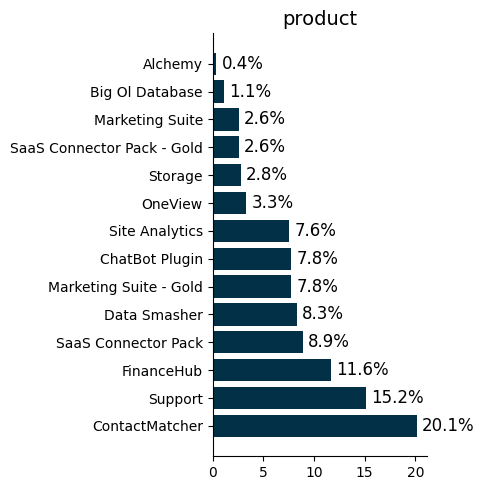

In [25]:
quantity_high = train.loc[train['quantity'] > 7]
eda_utils.plot_graph(data=quantity_high, features=['product'], barplot=True, figsize=(10,5))

In [26]:
high_demand_product = quantity_high.loc[quantity_high['product'].isin(['ContactMatcher','Support','FinanceHub'])]
high_demand_product.groupby('product')[['quantity','discount','profit','sales','unit_price']].mean().round(2)

,quantity,discount,profit,sales,unit_price
product,,,,,
ContactMatcher,9.40,0.36,12.03,567.23,58.60
FinanceHub,9.25,0.11,121.03,779.67,86.37
Support,9.27,0.08,53.90,128.27,13.84


#### Possíveis Causas
O produto ContactMatcher possui um desconto elevado em relação aos demais.  
O produto FinanceHub pode haver uma campanha de marketing mais forte ou mais oferta aos clientes, pois possui um lucro significativo.  
O produto Support possui um preço unitário baixo.

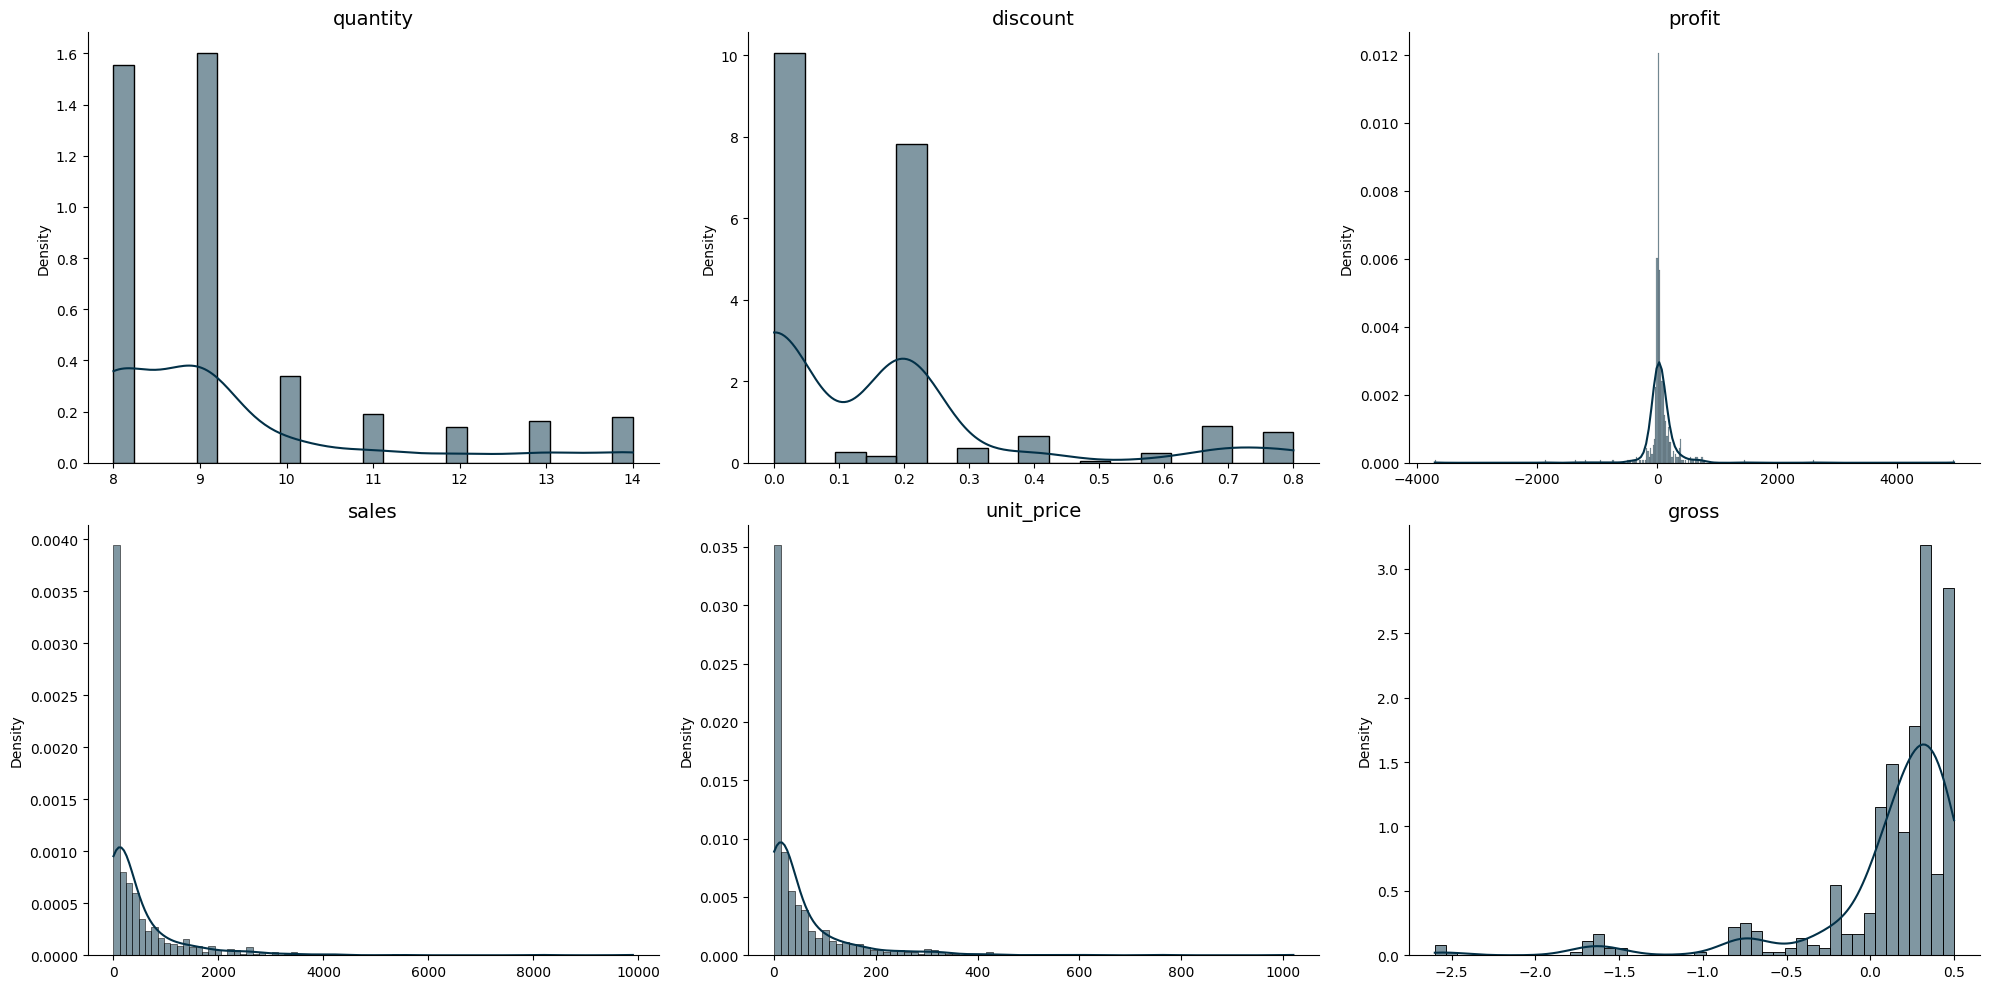

In [27]:
eda_utils.plot_graph(data=quantity_high, features=numerical_features, kde=True, figsize=(20,10))

Verificar lucro médio com e sem desconto nesse grupo, pois aparentemente quanto maior a quantidade maior o desconto, o que é coerente, mas pode haver desconto elevado nessa condição.  
Quantidades elevadas não possui diferença visual no lucro, pois ainda assim existem vendas com prejuízo e um pico em 0 e proximo disso.  
Mesmo com quantidades elevadas os valores das vendas estão concentrados em valores muito baixos, com pixo próximo a 0.  
Aparentemente existem vendas em massa de produtos baratos, pois o preço unitário está concentrado próximo a 0.

In [28]:
quantity_df = train.copy()
quantity_df['quantity_group'] = quantity_df['quantity'].apply(lambda x: 'High' if x > 7 else 'Low')
quantity_df.groupby('quantity_group')[['profit', 'discount', 'unit_price']].mean().round(2)

,profit,discount,unit_price
quantity_group,,,
High,61.45,0.16,54.56
Low,27.14,0.16,61.56


In [29]:
df_pos = quantity_df[quantity_df['profit'] > 0]
df_neg = quantity_df[quantity_df['profit'] <= 0]

profit_no_discount_pos = df_pos['profit'] / (1 - df_pos['discount'])
profit_no_discount_neg = df_neg['profit'] / (1 + df_neg['discount'])

print("Média lucro com desconto:", df_pos['profit'].mean())
print("Média lucro sem desconto:", profit_no_discount_pos.mean())
print('-'*60)
print("Média prejuízo com desconto:", df_neg['profit'].mean())
print("Média prejuízo sem desconto:", profit_no_discount_neg.mean())

Média lucro com desconto: 55.128602378731344
Média lucro sem desconto: 58.715570143007966
------------------------------------------------------------
Média prejuízo com desconto: -76.17780159948816
Média prejuízo sem desconto: -50.251176911909795


Mesmo com preço unitário mais baixo, o lucro absoluto é maior. Isso sugere que o ganho está no volume vendido.  
A política de desconto não está variando conforme o tamanho do pedido, o que pode ser bom para a margem. Porém, talvez haja oportunidade de aplicar descontos progressivos com cautela para aumentar ainda mais o volume.

In [30]:
quantity_high['gross'] = quantity_high['profit'] / (quantity_high['quantity'] * quantity_high['unit_price'])

In [31]:
quantity_high.groupby('product')[['profit','quantity', 'discount', 'unit_price', 'gross']].mean().round(2).sort_values(by='profit')

,profit,quantity,discount,unit_price,gross
product,,,,,
Storage,7.71,9.80,0.15,3.30,0.28
ContactMatcher,12.03,9.40,0.36,58.60,-0.22
Big Ol Database,15.91,8.50,0.22,330.69,0.07
ChatBot Plugin,17.76,8.88,0.08,10.37,0.24
Marketing Suite - Gold,44.24,9.50,0.08,57.34,0.08
OneView,50.99,8.94,0.22,71.34,-0.38
SaaS Connector Pack,51.44,9.19,0.12,24.12,0.19
Support,53.90,9.27,0.08,13.84,0.40
SaaS Connector Pack - Gold,60.04,8.64,0.06,16.79,0.43


Todos os produtos possuem a mesma média de quantidade (aproximadamente 4 no grupo com todos os registros e 9 no grupo com quantidades elevadas).  
Os produtos Big Ol Database e Alchemy possuem os maiores preços unitários, porém o produto Alchemy com a mesma média vendida possui uma diferença elevada no lucro. O que é contribuído também pelo desconto, já que o produto Big Ol Database uma média de 30% de deconto com todos os registros e 22% no grupo de quantidades elevadas.  
O produto Marketing Suite apesar de ser o terceiro com maior valor unitário possui prejuízo nas vendas com todos os produtos, conseguindo ficar positivo apenas em vendas com maiores quantidades.  
O produto Data Smasher apesar de ter o valor unitário relativamente baixo, está entre os 3 mais lucrativos em ambos grupos.  
Os produtos ContactMatcher e OneView possuem margem negativa em ambos grupos.

In [32]:
train.groupby('segment')[['profit','quantity', 'discount', 'unit_price', 'gross']].mean().round(2).sort_values(by='profit')

,profit,quantity,discount,unit_price,gross
segment,,,,,
SMB,26.60,3.74,0.16,60.66,0.11
Enterprise,32.32,3.79,0.15,63.27,0.15
Strategic,32.69,3.85,0.16,60.53,0.12


Não existe uma diferença elevada em vendas por segmento. Mas podemos realizar campanhas ou tentar aumentar a quantidade de vendas para o seguimento Strategic, pois mesmo com o segmento SMB concentrando mais da metade das vendas, ainda assim o lucro é menor.

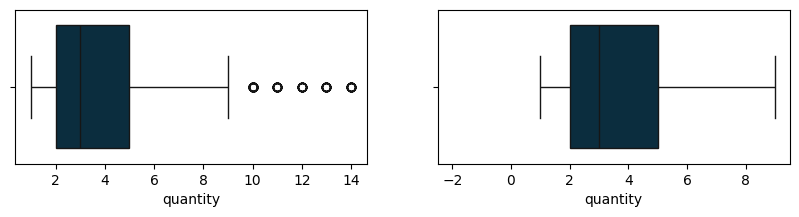

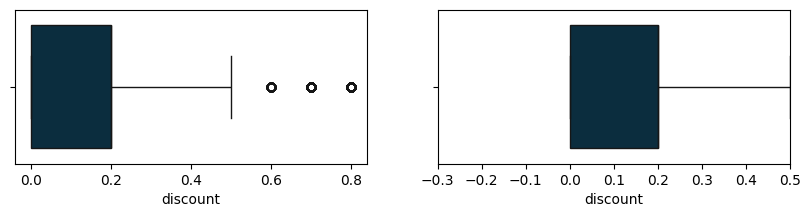

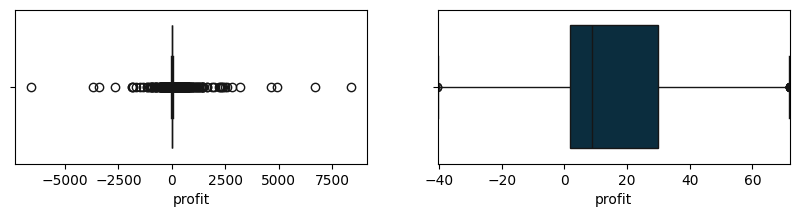

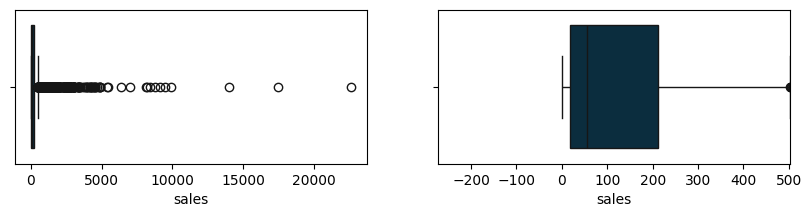

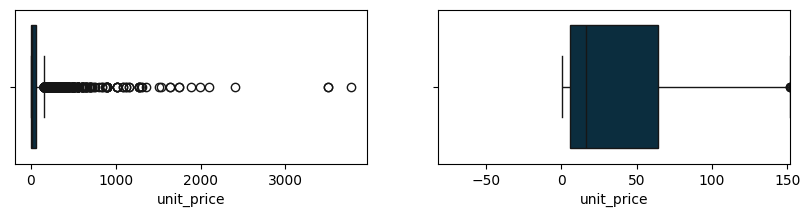

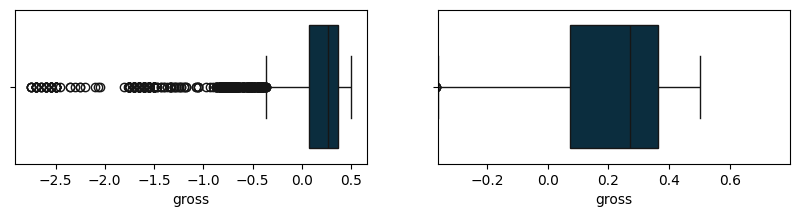

In [33]:
for feature in numerical_features: 
    q1 = train[feature].quantile(0.25)
    q3 = train[feature].quantile(0.75)
    amplitude = q3 - q1

    sns.set_palette(['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33'])
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(10,2)
    sns.boxplot(x=train[feature], ax=ax1)
    ax2.set_xlim(q1 - 1.5 * amplitude, q3 + 1.5 * amplitude)
    sns.boxplot(x=train[feature], ax=ax2)

In [34]:
train = train.drop(columns=['order_id','contact_name'], axis=1)

categorical_features = train.select_dtypes('object').columns.tolist()

print(f'\nO dataset possui {len(categorical_features)} variáveis categóricas.')
print(categorical_features)


O dataset possui 7 variáveis categóricas.
['country', 'city', 'region', 'subregion', 'industry', 'segment', 'product']


In [35]:
for feature in categorical_features:
    print('-'*40)
    print(f'Há {train[feature].nunique()} valores únicos')
    print(train[feature].value_counts(normalize=True))
    print()

----------------------------------------
Há 48 valores únicos
country
United States           0.200000
United Kingdom          0.112320
Japan                   0.101063
France                  0.057536
Australia               0.050031
Canada                  0.047655
Mexico                  0.047530
Germany                 0.038899
Brazil                  0.027142
Spain                   0.025516
Sweden                  0.024640
Chile                   0.022889
Finland                 0.019387
Russia                  0.017136
South Africa            0.016010
India                   0.015009
South Korea             0.013258
Argentina               0.012883
Belgium                 0.012758
Ireland                 0.011632
Philippines             0.011132
China                   0.010256
Italy                   0.010256
Saudi Arabia            0.008755
Luxembourg              0.007755
Portugal                0.006754
Singapore               0.006754
Poland                  0.006254
United

In [36]:
print(f'Haviam {len(train['country'].unique())} países distintos na base de dados')
print('-'*50)
top_countrys = train['country'].value_counts().nlargest(10).index
train['country'] = train['country'].apply(lambda x: x if x in top_countrys else 'Others')
print(f'Há {len(train['country'].unique())} países distindo na base de dados')

Haviam 48 países distintos na base de dados
--------------------------------------------------
Há 11 países distindo na base de dados


In [37]:
print(f'Haviam {len(train['city'].unique())} cidades distintas na base de dados')
print('-'*50)
top_citys = train['city'].value_counts().nlargest(20).index
train['city'] = train['city'].apply(lambda x: x if x in top_citys else 'Others')
print(f'Há {len(train['city'].unique())} cidades distintas na base de dados')

Haviam 252 cidades distintas na base de dados
--------------------------------------------------
Há 21 cidades distintas na base de dados


In [38]:
print(f'Quantidade de produtos que tiveram prejuízo na venda {len(train.loc[train['profit'] < 0,'product'].unique())}')
print(f'Nome dos produtos que tiveram prejuízo na venda {train.loc[train['profit'] < 0,'product'].unique()}')
print('-'*60)
print(f'Quantidade de produtos que tiveram lucro na venda {len(train.loc[train['profit'] > 0,'product'].unique())}')
print(f'Nome dos produtos que tiveram lucro na venda {train.loc[train['profit'] > 0,'product'].unique()}')
print('-'*60)
print(f'Quantidade de produtos {len(train['product'].unique())}')
print(f'Nome dos produtos {train['product'].unique()}')

Quantidade de produtos que tiveram prejuízo na venda 11
Nome dos produtos que tiveram prejuízo na venda ['Marketing Suite - Gold' 'ContactMatcher' 'SaaS Connector Pack'
 'Marketing Suite' 'Site Analytics' 'FinanceHub' 'OneView' 'Storage'
 'Big Ol Database' 'Support' 'Data Smasher']
------------------------------------------------------------
Quantidade de produtos que tiveram lucro na venda 14
Nome dos produtos que tiveram lucro na venda ['Support' 'FinanceHub' 'ChatBot Plugin' 'ContactMatcher' 'Site Analytics'
 'Storage' 'Data Smasher' 'SaaS Connector Pack' 'Marketing Suite - Gold'
 'SaaS Connector Pack - Gold' 'Marketing Suite' 'OneView'
 'Big Ol Database' 'Alchemy']
------------------------------------------------------------
Quantidade de produtos 14
Nome dos produtos ['Support' 'FinanceHub' 'Marketing Suite - Gold' 'ContactMatcher'
 'ChatBot Plugin' 'Site Analytics' 'Storage' 'SaaS Connector Pack'
 'Data Smasher' 'SaaS Connector Pack - Gold' 'Marketing Suite' 'OneView'
 'Big Ol Da

In [39]:
basket = df.groupby(['order_id', 'product'])['quantity'].sum().unstack().fillna(0)

basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
frequent_items = apriori(basket, min_support=0.002, use_colnames=True)

rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)

cross_sell_rules = rules[(rules['confidence'] > 0.5) & (rules['lift'] > 1.1)]
cross_sell_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
349,"(OneView, Marketing Suite - Gold)",(ContactMatcher),0.006788,0.607143,1.959522
373,"(Storage, Marketing Suite - Gold)",(ContactMatcher),0.003993,0.540541,1.744567
391,"(OneView, SaaS Connector Pack - Gold)",(ContactMatcher),0.002196,0.523810,1.690568
417,"(SaaS Connector Pack, Storage)",(ContactMatcher),0.004592,0.560976,1.810520
749,"(Data Smasher, FinanceHub, ChatBot Plugin)",(ContactMatcher),0.002196,0.578947,1.868523
792,"(FinanceHub, ChatBot Plugin, SaaS Connector Pack)",(ContactMatcher),0.002595,0.520000,1.678273
848,"(Site Analytics, ChatBot Plugin, SaaS Connecto...",(ContactMatcher),0.002595,0.541667,1.748201
918,"(Data Smasher, FinanceHub, Marketing Suite - G...",(ContactMatcher),0.002396,0.545455,1.760426
945,"(Data Smasher, FinanceHub, Site Analytics)",(ContactMatcher),0.002795,0.583333,1.882678
974,"(Data Smasher, Site Analytics, Marketing Suite...",(ContactMatcher),0.002396,0.545455,1.760426


### Conclusões

Esta etapa de EDA forneceu insights valiosos que servirão como base para a modelagem preditiva de faturamento. Os principais aprendizados foram:

#### Comportamento de Vendas
- As vendas possuem uma certa sazonalidade, com oscilações claras mês a mês.
- Identificamos alguns picos pontuais que podem ser investigados para entender campanhas, lançamentos ou sazonalidade.

#### Produtos Relevantes
- Produtos como Alchemy, Big OI Database e Marketing Suite são caros e vendem pouco, mas aparecem entre os maiores responsáveis pelo faturamento total (regra de Pareto).
- São potenciais produtos âncora, que sustentam boa parte da receita com baixo volume.

#### Preço, Desconto e Lucro
- A correlação entre desconto e margem (gross) é fortemente negativa (-0.87), indicando que, embora os descontos possam impulsionar vendas, reduzem significativamente a lucratividade.
- Preço unitário está positivamente correlacionado com vendas e lucro, o que pode indicar que produtos mais caros são vendidos de forma estratégica e com maior retorno.

#### Regras de Associação
- Produtos como ContactMatcher e Support aparecem com alta frequência como consequentes em regras de associação.
- Isso indica alto potencial para vendas cruzadas (cross-sell) e campanhas combinadas com produtos de entrada como Marketing Suite - Gold e OneView.